In [ ]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python Docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load

In [ ]:
import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)

# Input data files are available in the read-only "../input/" directory
# For example, running this (by clicking run or pressing Shift+Enter) will list all files under the input directory

import os
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))

# You can write up to 20GB to the current directory (/kaggle/working/) that gets preserved as output when you create a version using "Save & Run All" 
# You can also write temporary files to /kaggle/temp/, but they won't be saved outside of the current session

In [ ]:
import gc
import os
import logging
import warnings
import seaborn as sns
import matplotlib.pyplot as plt
import lightgbm as lgb
from tqdm import tqdm_notebook as tqdm
from sklearn.metrics import mean_squared_error
from sklearn.metrics import roc_auc_score, roc_curve
from sklearn.model_selection import StratifiedKFold
warnings.filterwarnings('ignore')

1. 데이터 columns : 200개
2. train, test 각 200,000개
2. 데이터 상관관계 분석, 차원감소기법 등 활용해야 할 듯..
4. id_code로 target예측
5. target은 0, 1로 구분(mean 찍으면 0.100490나옴. 10%정도?)
- binary classification


# 1. 데이터 불러오기

In [ ]:
data_path = "../input/santander-customer-transaction-prediction/"

In [ ]:
train = pd.read_csv(data_path + 'train.csv')

In [ ]:
test = pd.read_csv(data_path + 'test.csv')

In [ ]:
train.info()

# 2. EDA
### 2-1). Fake데이터 찾기
- test데이터 200000개 중 100000개는 가공된 데이터임을 알 수 있음
- unique함수를 써서 데이터의 종류와 갯수를 비교하여 동일한 함수를 색인

In [ ]:
df_test = test.drop(['ID_code'], axis=1)
df_test = df_test.values

unique_samples = []
unique_count = np.zeros_like(df_test)
for feature in tqdm(range(df_test.shape[1])):
    _, index_, count_ = np.unique(df_test[:, feature], return_counts=True, return_index=True)
    unique_count[index_[count_ == 1], feature] += 1
    
real_sample_indexes = np.argwhere(np.sum(unique_count, axis=1) > 0)[:, 0]
synthetic_sample_indexes = np.argwhere(np.sum(unique_count, axis=1) == 0)[:, 0]

print(len(real_sample_indexes))
print(len(synthetic_sample_indexes))

In [ ]:
df_test_real = df_test[real_sample_indexes].copy()

generator_for_each_synthetic_sample = []
for cur_sample_index in tqdm(synthetic_sample_indexes[:20000]):
    cur_synthetic_sample = df_test[cur_sample_index]
    potential_generators = df_test_real == cur_synthetic_sample
    
    features_mask = np.sum(potential_generators, axis=0) == 1
    verified_generators_mask = np.any(potential_generators[:, features_mask], axis=1)
    verified_generators_for_sample = real_sample_indexes[np.argwhere(verified_generators_mask)[:, 0]]
    generator_for_each_synthetic_sample.append(set(verified_generators_for_sample))

In [ ]:
public_LB = generator_for_each_synthetic_sample[0]
for x in tqdm(generator_for_each_synthetic_sample):
    if public_LB.intersection(x):
        public_LB = public_LB.union(x)
        
private_LB = generator_for_each_synthetic_sample[1]
for x in tqdm(generator_for_each_synthetic_sample):
    if private_LB.intersection(x):
        private_LB = private_LB.union(x)
        
print(len(public_LB))
print(len(private_LB))

In [ ]:
with open("public_LB", "w") as public:
    public.write(str(public_LB))
    
with open("private_LB", "w") as private:
    private.write(str(private_LB))

### 2-2). Feature 탐색

In [ ]:
def plot_feature_scatter(df1, df2, features):
    i = 0
    sns.set_style('whitegrid')
    plt.figure()
    fig, ax = plt.subplots(4, 4, figsize=(14, 14))
    
    for feature in features:
        i += 1
        plt.subplot(4, 4, i)
        plt.scatter(df1[feature], df2[feature], marker='+')
        plt.xlabel(feature, fontsize=9)
    plt.show()

In [ ]:
features = ['var_0', 'var_1','var_2','var_3', 'var_4', 'var_5', 'var_6', 'var_7', 
           'var_8', 'var_9', 'var_10','var_11','var_12', 'var_13', 'var_14', 'var_15', 
           ]
plot_feature_scatter(train[::20], test[::20], features)

In [ ]:
sns.countplot(train['target'], palette='Set3')

# target의 비율 계산
# 1. 값으로 계산
# train.target.value_counts()[1] / train.shape[0] * 100

# 2. describe함수 사용
target_percent = train.target.describe()[1] * 100
print(f"타겟 비율 {target_percent}" % target_percent)

# -> 데이터 비율이 unbalanced 함

### 2-3). 차원축소기법
- 확률밀도함수(PDF)를 이용하여 데이터를 histogram형태로 표현
- 200개의 변수, 200000개의 내역은 데이터 양이 크기때문에, 데이터를 축소할 필요가 있음.


In [ ]:
def plot_feature_distribution(df1, df2, label1, label2, features):
    i = 0
    sns.set_style('whitegrid')
    plt.figure()
    fig, ax = plt.subplots(10,10,figsize=(18,22))

    for feature in features:
        i += 1
        plt.subplot(10,10,i)
        sns.distplot(df1[feature], hist=False,label=label1)
        sns.distplot(df2[feature], hist=False,label=label2)
        plt.xlabel(feature, fontsize=9)
        locs, labels = plt.xticks()
        plt.tick_params(axis='x', which='major', labelsize=6, pad=-6)
        plt.tick_params(axis='y', which='major', labelsize=6)
    plt.show();

In [ ]:
t0 = train.loc[train['target'] == 0]
t1 = train.loc[train['target'] == 1]
features = train.columns.values[2:102]
plot_feature_distribution(t0, t1, '0', '1', features)

In [ ]:
# 평균의 확률밀도 함수
plt.figure(figsize=(16,6))
features = train.columns.values[2:202]
plt.title("Distribution of mean values per row in the trian and test set")
sns.distplot(train[features].mean(axis=1), color="green", kde=True, bins=120, label="train")
sns.distplot(test[features].mean(axis=1), color="blue", kde=True, bins=120, label="test")
plt.legend()
plt.show()

- target이 0일 때, 1일 때의 차이가 가장 큰 81번, 139번을 기준으로 시각화

In [ ]:
feat1, feat2 = 'var_81', 'var_139'

fig = plt.subplots(figsize=(15, 5))

plt.subplot(1, 2, 1)
sns.kdeplot(train[feat1][train['target']==0], shade=True, color='b', label='target = 0')
sns.kdeplot(train[feat1][train['target']==1], shade=True, color='r', label='target = 0')
plt.title(feat1)
plt.xlabel('Feature Values')
plt.ylabel('Probability')

plt.subplot(1, 2, 2)
sns.kdeplot(train[feat2][train['target']==0], shade=True, color='b', label='target = 0')
sns.kdeplot(train[feat2][train['target']==1], shade=True, color='r', label='target = 0')
plt.title(feat2)
plt.xlabel('Feature Values')
plt.ylabel('Probability')

### 2-4). overfitting 방지
- 확률밀도함수(PDF) histogram을 사용 할 경우, overfitting을 어떻게 방지할 수 있을까?

In [ ]:
# 예측 시 IQR_multiplier, bin_bandwidth_multiplier를 변수로 하여 조절 가능하도록 PDF함수 작성

from sklearn.neighbors import KernelDensity
from operator import itemgetter

feat = 'var_81'

def calculate_pdf_difference(feat, df_feature, df_target, IQR_multiplier, bin_bandwidth_multiplier, print_number_bins):
    #Agreggating feature values in bin format using the Freedman-Diaconis rule
    IQR = df_feature[feat].quantile([0.75]).values - df_feature[feat].quantile([0.25]).values #Interquartile range (IQR)
    n = len(df_feature[feat])
    bin_size = IQR_multiplier*IQR/n**(1/3)
    bin_number = int(np.round((df_feature[feat].max() - df_feature[feat].min())/bin_size))
    binvalues = pd.cut(df_feature[feat], bins = bin_number, labels = range(bin_number)).astype('float')
    
    if print_number_bins:
        print('There are {} bins in the feature {}'.format(bin_number, feat))

    #Calculate the PDFs using the df_target
    pdf_0 = KernelDensity(kernel='gaussian', bandwidth=bin_size*bin_bandwidth_multiplier)
    pdf_0.fit(np.array(df_target[feat][df_target['target'] == 0]).reshape(-1,1))

    pdf_1 = KernelDensity(kernel='gaussian', bandwidth=bin_size*bin_bandwidth_multiplier)
    pdf_1.fit(np.array(df_target[feat][df_target['target'] == 1]).reshape(-1,1))

    #Creates an X array with the average feature value for each bin
    x = np.array(np.arange(min(df_feature[feat]) + bin_size/2 ,max(df_feature[feat]), bin_size)).reshape(-1,1)

    #gets the pdf values based on the X array
    log_pdf_0 = np.exp(pdf_0.score_samples(x))
    log_pdf_1 = np.exp(pdf_1.score_samples(x))

    #creates a dictionary that links the bin number with the PDFs value difference
    pdf_dict = dict()
    for i in range(bin_number):
        pdf_dict[i] = log_pdf_1[i] - log_pdf_0[i] 

    #gets the PDF difference for each row of the dataset based on its equivalent bin.
    bin_pdf_values = np.array(itemgetter(*list(binvalues))(pdf_dict))

    return bin_pdf_values, x, log_pdf_0, log_pdf_1


In [ ]:
full = pd.concat([train, test], sort = False)

In [ ]:

feat1, feat2 = 'var_81', 'var_139'

fig = plt.subplots(figsize=(15, 5))

#plot pdf feat 1
bin_pdf_values, x, log_pdf_0, log_pdf_1 = calculate_pdf_difference(feat = feat1, df_feature = full, df_target = train, IQR_multiplier = 2, bin_bandwidth_multiplier = 1.5, print_number_bins = True)

plt.subplot(1, 2, 1)

sns.kdeplot(train[feat1][train['target'] == 0], shade=False, color="b", label = 'target = 0')
sns.kdeplot(train[feat1][train['target'] == 1], shade=False, color="r", label = 'target = 1')
plt.plot(x, log_pdf_0)
plt.plot(x, log_pdf_1) 
plt.title(feat1)
plt.xlabel('Feature Values')
plt.ylabel('Probability')

#plot pdf feat 2
bin_pdf_values, x, log_pdf_0, log_pdf_1 = calculate_pdf_difference(feat = feat2, df_feature = full, df_target = train, IQR_multiplier = 2, bin_bandwidth_multiplier = 1.5, print_number_bins = True)

plt.subplot(1, 2, 2)
sns.kdeplot(train[feat2][train['target'] == 0], shade=False, color="b", label = 'target = 0')
sns.kdeplot(train[feat2][train['target'] == 1], shade=False, color="r", label = 'target = 1')
plt.plot(x, log_pdf_0)
plt.plot(x, log_pdf_1) 
plt.title(feat2)
plt.xlabel('Feature Values')
plt.ylabel('Probability')

plt.show()

- 위의 예측 그래프에서 target이 1일 때 IQR, bin_bandwidth_multiplier를 조절해주지 않으면, overfitting이 발생
- 그 이유는 target이 1일 때의 데이터 수가 적기 때문에 특정 부분에서 갑자기 튀는 값이 있는 경우 이를 예측하기 위함
- 아래의 그래프로 확인 가능

In [ ]:
var_81_0 = train['var_81'][train['target'] == 0].sort_values().reset_index(drop=True)
var_81_1 = train['var_81'][train['target'] == 1].sort_values().reset_index(drop=True)

sns.displot(var_81_0, color="b", label = 'target = 0')
sns.displot(var_81_1, color="r", label = 'target = 1')

- 아래와 같이 IQR_multiplier, bin_bandwidth_multiplier를 조절하여 overfitting을 방지할 수 있음

In [ ]:
print('-----------------------------------------------')
IQR_multiplier = 3
bin_bandwidth_multiplier = 3
print('IQR_multiplier', IQR_multiplier)
print('bin_bandwidth_multiplier', bin_bandwidth_multiplier)
print('-----------------------------------------------')
fig = plt.subplots(figsize=(15, 5))
#plot pdf feat 1
bin_pdf_values, x, log_pdf_0, log_pdf_1 = calculate_pdf_difference(feat = feat1, df_feature = full, df_target = train, IQR_multiplier = IQR_multiplier, bin_bandwidth_multiplier = bin_bandwidth_multiplier, print_number_bins = True)

plt.subplot(1, 2, 1)

sns.kdeplot(train[feat1][train['target'] == 0], shade=False, color="b", label = 'target = 0')
sns.kdeplot(train[feat1][train['target'] == 1], shade=False, color="r", label = 'target = 1')
plt.plot(x, log_pdf_0)
plt.plot(x, log_pdf_1) 
plt.title(feat1)
plt.xlabel('Feature Values')
plt.ylabel('Probability')

#plot pdf feat 2
bin_pdf_values, x, log_pdf_0, log_pdf_1 = calculate_pdf_difference(feat = feat2, df_feature = full, df_target = train, IQR_multiplier = IQR_multiplier, bin_bandwidth_multiplier = bin_bandwidth_multiplier, print_number_bins = True)

plt.subplot(1, 2, 2)
sns.kdeplot(train[feat2][train['target'] == 0], shade=False, color="b", label = 'target = 0')
sns.kdeplot(train[feat2][train['target'] == 1], shade=False, color="r", label = 'target = 1')
plt.plot(x, log_pdf_0)
plt.plot(x, log_pdf_1) 
plt.title(feat2)
plt.xlabel('Feature Values')
plt.ylabel('Probability')

plt.show()

### 2-5). 상관관계 분석
- target과 관련있는, 혹인 서로 관계있는 변수가 있는지 찾아보고 예측 알고리즘에 적용 가능한지 고민해보기
- 확인 결과 0.1 이상이 없음. 서로 관계있는 변수는 없으며, 변수간에 관계성을 이용하기는 어려움
- corr함수는 변수간의 pearson상관계수를 계산

In [ ]:
train_corr = train.corr()
train_corr

In [ ]:
train_corr_target = pd.DataFrame(train_corr['target'] > 0.1)
train_corr_target.value_counts()

In [ ]:
# target과 관련있는 상위 10개의 변수
train_corr[train_corr['target'].abs() > 0.1].T.sort_values(['target'], ascending = False).head(10)
# 절대값으로 순위 정렬해서 써야 함

In [ ]:
# 변수 서로간의 상관계수
correlations = train[features].corr().abs().unstack().sort_values(kind='quicksort').reset_index()
correlations = correlations[correlations['level_0'] != correlations['level_1']]
# correlations.head(10)
correlations.tail(10)

# 3. 성능 향상을 위한 개선안
### 3-1). 누적분포함수 사용
 - 선행연구자들은 확률밀도함수(PDF)를 사용하여 1, 0일때를 구분함
 - 누적분포함수(CDF)를 써보자! -> 누적분포함수는 확률밀도함수보다 구분이 어려움

In [ ]:
sns.ecdfplot(var_81_0, color="b", label = 'target = 0')
sns.ecdfplot(var_81_1, color="r", label = 'target = 0')

In [ ]:
var_139_0 = train['var_139'][train['target'] == 0]
var_139_1 = train['var_139'][train['target'] == 1]

sns.ecdfplot(var_139_0, color="b", label = 'target = 0')
sns.ecdfplot(var_139_1, color="r", label = 'target = 0')

In [ ]:
# 확률밀도 함수가 비슷했던 변수는 누적분포함수로 해도 비슷하게 나옴
var_45_0 = train['var_45'][train['target'] == 0]
var_45_1 = train['var_45'][train['target'] == 1]

sns.ecdfplot(var_45_0, color="b", label = 'target = 0')
sns.ecdfplot(var_45_1, color="r", label = 'target = 0')

### 3-2). 로그값 사용
- 데이터에 로그를 취하면, 데이터 scale이 작아지고, 상대적인 차이가 커지기 때문에, target 0일때와 1일때의 차이를 더 크게 구분할 수 있을 것으로 보임
- 확인 결과 차이가 더 크게 구분되는 것을 볼 수 있음

In [ ]:
sns.kdeplot(train['var_45'][train['target']==0], shade=True, color='b', label='target = 0')
sns.kdeplot(train["var_45"][train['target']==1], shade=True, color='r', label='target = 0')
plt.title("var_45")
plt.xlabel('Feature Values')
plt.ylabel('Probability')

In [ ]:
var_45_0 = np.log(train['var_45'][train['target'] == 0])
var_45_1 = np.log(train['var_45'][train['target'] == 1])

sns.kdeplot(var_45_0, color="b", label = 'target = 0')
sns.kdeplot(var_45_1, color="r", label = 'target = 0')

# 3-3). 집계값을 추가 변수로 사용
- 각 데이터들의 합, 최대, 최소 등 집계값을 추가 변수로 사용

In [ ]:
idx = features = train.columns.values[2:202]
for df in [test, train]:
    df['sum'] = df[idx].sum(axis=1)
    df['min'] = df[idx].min(axis=1)
    df['max'] = df[idx].max(axis=1)
    df['mean'] = df[idx].mean(axis=1)
    df['std'] = df[idx].std(axis=1)
    df['skew'] = df[idx].skew(axis=1)
    df['kurt'] = df[idx].kurtosis(axis=1)
    df['med'] = df[idx].median(axis=1)

    

In [ ]:
train[train.columns[202:]].head()

In [ ]:
test[test.columns[202:]].head()

In [ ]:
def plot_new_feature_distribution(df1, df2, label1, label2, features):
    i = 0
    sns.set_style('whitegrid')
    plt.figure()
    fig, ax = plt.subplots(2,4,figsize=(18,8))

    for feature in features:
        i += 1
        plt.subplot(2,4,i)
        sns.kdeplot(df1[feature], bw=0.5,label=label1)
        sns.kdeplot(df2[feature], bw=0.5,label=label2)
        plt.xlabel(feature, fontsize=11)
        locs, labels = plt.xticks()
        plt.tick_params(axis='x', which='major', labelsize=8)
        plt.tick_params(axis='y', which='major', labelsize=8)
    plt.show();

In [ ]:
t0 = train.loc[train['target']==0]
t1 = train.loc[train['target']==1]
features = train.columns.values[202:]
plot_new_feature_distribution(t0, t1, 'target:0', 'target:1',features)

# 4. 예측 모델 만들기
### 4-1). 모든 값에 log를 적용
- log가 적용되지 않는 column은 원본값을 사용(train, test동일하게 적용 가능한 column만 적용)

In [ ]:
train1 = train.copy()
train1.iloc[:, 2:202] = np.log(train1.iloc[:, 2:202])
test1 = test.copy()
test1.iloc[:, 1:201] = np.log(test1.iloc[:, 1:201])

In [ ]:
(12-10)/12

In [ ]:
(np.log(12) - np.log(10)) / np.log(12)

In [ ]:
train.head()

In [ ]:
print(train1.isnull().sum())
print(test1.isnull().sum())

In [ ]:
train2 = train1.dropna(axis = 1)
test2 = test1.dropna(axis = 1)

In [ ]:
train2 = train2.drop('var_101', axis = 1)
test2 = test2.drop('var_114', axis = 1)

In [ ]:
inter = np.intersect1d(train2.columns[2:], test2.columns[1:])
inter[:]

In [ ]:
train10 = train[train[np.setdiff1d(train.columns, inter)].columns[2:]]
test10 = test[test[np.setdiff1d(test.columns, inter)].columns[1:]]


In [ ]:
np.setdiff1d(np.array(train1.columns), inter)

In [ ]:
np.setdiff1d(np.array(test1.columns), inter)

In [ ]:
train = pd.concat([train2, train10], axis = 1)
train

In [ ]:
test = pd.concat([test2, test10], axis = 1)
test

- log적용 후 집계값 다시 계산하여 추가

In [ ]:
idx = features = train.columns.values[2:70]
for df in [test, train]:
    df['sum'] = df[idx].sum(axis=1)
    df['min'] = df[idx].min(axis=1)
    df['max'] = df[idx].max(axis=1)
    df['mean'] = df[idx].mean(axis=1)
    df['std'] = df[idx].std(axis=1)
    df['skew'] = df[idx].skew(axis=1)
    df['kurt'] = df[idx].kurtosis(axis=1)
    df['med'] = df[idx].median(axis=1)

In [ ]:
train[train.columns[70:]].head()

### 4-2). lightGBM사용

In [ ]:
features = [c for c in train.columns if c not in ['ID_code', 'target']]
target = train['target']

In [ ]:
# parameter 정의

param = {
    'bagging_freq': 5,
    'bagging_fraction': 0.4,
    'boost_from_average':'false',
    'boost': 'gbdt',
    'feature_fraction': 0.05,
    'learning_rate': 0.01,
    'max_depth': -1,  
    'metric':'auc',
    'min_data_in_leaf': 80,
    'min_sum_hessian_in_leaf': 10.0,
    'num_leaves': 13,
    'num_threads': 8,
    'tree_learner': 'serial',
    'objective': 'binary', 
    'verbosity': 1
}

In [ ]:
folds = StratifiedKFold(n_splits=10, shuffle=False, random_state=44000)
oof = np.zeros(len(train))
predictions = np.zeros(len(train))
feature_importance_df = pd.DataFrame()

for fold_, (trn_idx, val_idx) in enumerate(folds.split(train.values, target.values)):
    print("Fold {}".format(fold_))
    trn_data = lgb.Dataset(train.iloc[trn_idx][features], label=target.iloc[trn_idx])
    val_data = lgb.Dataset(train.iloc[val_idx][features], label=target.iloc[val_idx])

    num_round = 500000
    clf = lgb.train(param, trn_data, num_round, valid_sets = [trn_data, val_data], verbose_eval=1000, early_stopping_rounds = 3000)
    oof[val_idx] = clf.predict(train.iloc[val_idx][features], num_iteration=clf.best_iteration)
    
    fold_importance_df = pd.DataFrame()
    fold_importance_df["Feature"] = features
    fold_importance_df["importance"] = clf.feature_importance()
    fold_importance_df["fold"] = fold_ + 1
    feature_importance_df = pd.concat([feature_importance_df, fold_importance_df], axis=0)
    
    predictions += clf.predict(test[features], num_iteration=clf.best_iteration) / folds.n_splits

print("CV score: {:<8.5f}".format(roc_auc_score(target, oof)))

In [ ]:
cols = (feature_importance_df[["Feature", "importance"]]
        .groupby("Feature")
        .mean()
        .sort_values(by="importance", ascending=False)[:150].index)
best_features = feature_importance_df.loc[feature_importance_df.Feature.isin(cols)]

plt.figure(figsize=(14,28))
sns.barplot(x="importance", y="Feature", data=best_features.sort_values(by="importance",ascending=False))
plt.title('Features importance (averaged/folds)')
plt.tight_layout()
plt.savefig('FI.png')

In [ ]:
sub_df = pd.DataFrame({"ID_code":test["ID_code"].values})
sub_df["target"] = predictions
sub_df.to_csv("./submission2.csv", index=False)


# 5. 결과
- 데이터를 가공하지 않고 예측했을 경우, 0.89971달성(Public score기준)
- log가 적용가능한 데이터(70 columns)만 사용할 경우 0.78610달성
- log 적용(70 columns) + 원본 데이터(130 columns) 사용할 경우 0.89979달성(원본데이터 사용보다 0.0008 향상)

-> 가능한 원본데이터의 갯수를 유지하며 예측하는 것이 성능 향상이 됨

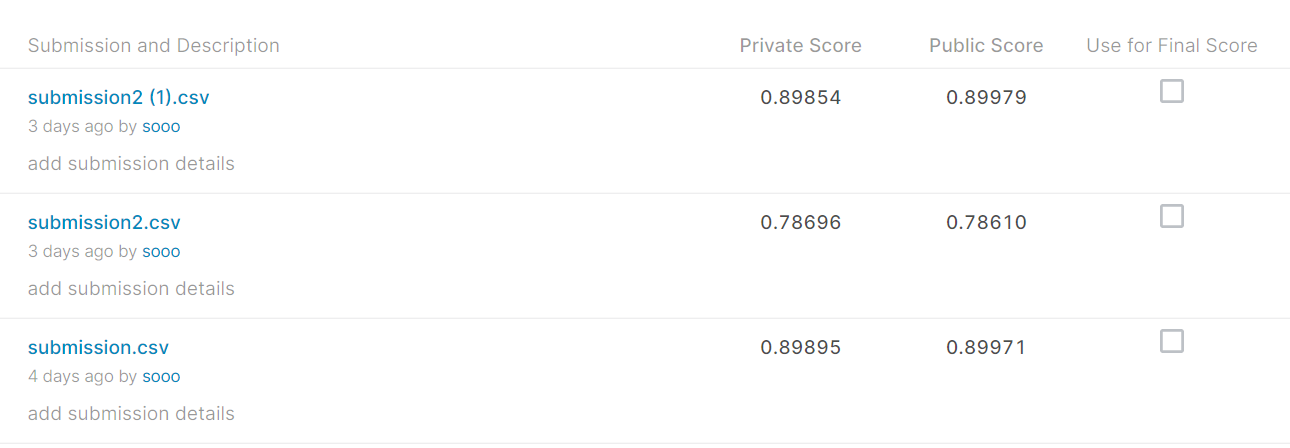